In [2]:
# Install dependencies as needed:
# pip install kagglehub[pandas-datasets]
import kagglehub
from kagglehub import KaggleDatasetAdapter
# Core numerical & plotting
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Model and helpers
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# Train/test splitting & cross-validation
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve

# Classification metrics & visualisers
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    plot_roc_curve,
    roc_curve,
    precision_recall_curve,
    auc,
    log_loss,
    brier_score_loss
)

# Calibration
from sklearn.calibration import calibration_curve

# Set the path to the file you'd like to load
file_path = "City_Types.csv"

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "youssefelebiary/industrial-residential-air-quality-classification",
  file_path,
  # Provide any additional arguments like 
  # sql_query or pandas_kwargs. See the 
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

print("First 5 records:", df.head())




C:\Users\cordo\AppData\Local\Temp\ipykernel_141928\2554586922.py:41: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(


First 5 records:                         Date    City     CO   NO2   SO2    O3  PM2.5  PM10  \
0  2024-01-01 00:00:00+00:00  Moscow  208.0  15.9  13.2  44.0    8.6   9.4   
1  2024-01-01 01:00:00+00:00  Moscow  207.0  17.4  13.7  44.0    8.6  10.5   
2  2024-01-01 02:00:00+00:00  Moscow  217.0  19.0  15.5  43.0   10.4  12.9   
3  2024-01-01 03:00:00+00:00  Moscow  231.0  21.0  20.7  36.0   12.3  15.3   
4  2024-01-01 04:00:00+00:00  Moscow  263.0  34.5  27.2  27.0   13.6  20.0   

         Type  
0  Industrial  
1  Industrial  
2  Industrial  
3  Industrial  
4  Industrial  


In [3]:
import numpy as np
import pandas as pd
# the functions below are used to implement logistic regression
# to classify the area based on air pollution content
# the data is taken from kaggle dataset: Industrial-Residential Air Quality Classification
# https://www.kaggle.com/datasets/youssefelebiary/industrial-residential-air-quality-classification

# keep b, but DO NOT add the column of 1's
X = df.drop('Type', axis=1).values   # no hstack here
b = 0.0

y = df['Type'].values
# Convert categorical labels to numerical values
y = np.where(y == 'Industrial', 1, 0)  # Industrial = 1, Residential = 0


w = np.zeros(X.shape[1]) # Initialize weights to zero






# Function to preprocess the data
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def predict_prob(X , w):
    z = np.dot(X, w) # Linear combination of inputs and weights
    return sigmoid(X @ w)  # Apply sigmoid function to the linear combination
def compute_cost(X, y, w, lam):
    m = len(y)
    p = predict_prob(X, w)
    p = np.clip(p, 1e-15, 1 - 1e-15)       # avoid log(0)

    data_loss = -(1/m) * np.sum(y*np.log(p) + (1-y)*np.log(1-p))
    reg_loss  = (lam/(2*m)) * np.sum(w[1:]**2)   # skip bias
    return data_loss + reg_loss


In [5]:
# implementing gradient descent
def gradient_descent(X, y, lr, lam,
                     n_iter=3000, verbose=500):
    m, n = X.shape
    w = np.zeros(n)               # includes bias
    history = []

    for i in range(n_iter):
        p = predict_prob(X, w)      # (m,)
        error = p - y               # (m,)

        # gradient: (n,)  [vectorised]
        grad = (X.T @ error) / m
        grad[1:] += (lam / m) * w[1:]   # no reg on bias

        # update
        w -= lr * grad

        if i % verbose == 0:
            cost = compute_cost(X, y, w, lam)
            history.append(cost)
            print(f"iter {i:4d}   cost = {cost:.4f}")

    # final cost
    history.append(compute_cost(X, y, w, lam))
    return w, history



In [6]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_raw  = df.drop(['Type','Date','City'], axis=1).values
X_scaled = scaler.fit_transform(X_raw)

# now add bias
X = np.hstack([np.ones((X_scaled.shape[0],1)), X_scaled])





In [7]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y)

# init weights
w = np.zeros(X_train.shape[1])

# train
w_learned, history = gradient_descent(
        X, y, lr=0.01, lam=0.1,
                     n_iter=300000, verbose=500)

# accuracy
preds = (predict_prob(X_test, w_learned) >= 0.5).astype(int)
acc   = (preds == y_test).mean()
print("Test accuracy:", acc)

iter    0   cost = 0.6895
iter  500   cost = 0.3635
iter 1000   cost = 0.3126
iter 1500   cost = 0.2854
iter 2000   cost = 0.2671
iter 2500   cost = 0.2535
iter 3000   cost = 0.2427
iter 3500   cost = 0.2337
iter 4000   cost = 0.2262
iter 4500   cost = 0.2196
iter 5000   cost = 0.2138
iter 5500   cost = 0.2086
iter 6000   cost = 0.2039
iter 6500   cost = 0.1996
iter 7000   cost = 0.1957
iter 7500   cost = 0.1921
iter 8000   cost = 0.1887
iter 8500   cost = 0.1855
iter 9000   cost = 0.1826
iter 9500   cost = 0.1798
iter 10000   cost = 0.1772
iter 10500   cost = 0.1747
iter 11000   cost = 0.1724
iter 11500   cost = 0.1702
iter 12000   cost = 0.1680
iter 12500   cost = 0.1660
iter 13000   cost = 0.1641
iter 13500   cost = 0.1622
iter 14000   cost = 0.1605
iter 14500   cost = 0.1588
iter 15000   cost = 0.1571
iter 15500   cost = 0.1556
iter 16000   cost = 0.1541
iter 16500   cost = 0.1526
iter 17000   cost = 0.1512
iter 17500   cost = 0.1498
iter 18000   cost = 0.1485
iter 18500   cost = 0

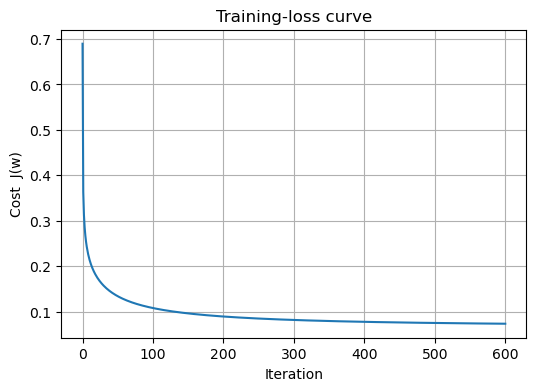

In [8]:
# Cost over iterations
# learning curve 

plt.figure(figsize=(6, 4))
plt.plot(history, color='tab:blue')
plt.xlabel('Iteration')
plt.ylabel('Cost  J(w)')
plt.title('Training-loss curve')
plt.grid(True)
plt.show()



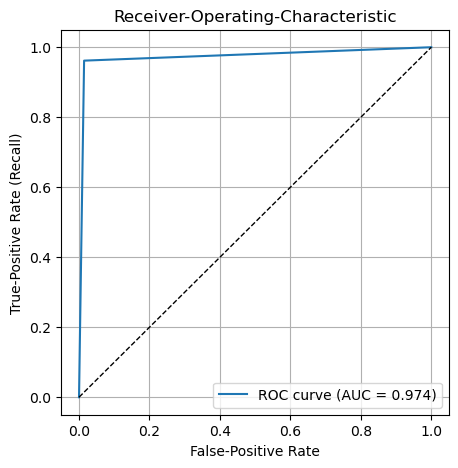

In [9]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False-Positive Rate')
plt.ylabel('True-Positive Rate (Recall)')
plt.title('Receiver-Operating-Characteristic')
plt.legend()
plt.grid(True)
plt.show()


Test size: 10541
0    5271
1    5270
dtype: int64


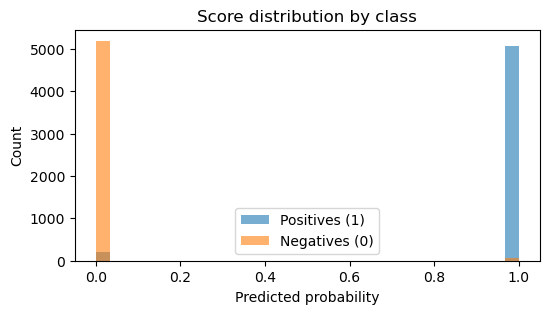

Unique probability values: 2


In [10]:
# 1. How many test samples and class balance?
print("Test size:", len(y_test))
print(pd.Series(y_test).value_counts())

# 2. Distribution of probability scores
plt.figure(figsize=(6,3))
plt.hist(preds[y_test==1], bins=30, alpha=0.6, label='Positives (1)')
plt.hist(preds[y_test==0], bins=30, alpha=0.6, label='Negatives (0)')
plt.xlabel("Predicted probability")
plt.ylabel("Count")
plt.title("Score distribution by class")
plt.legend()
plt.show()

# 3. How many distinct scores?
print("Unique probability values:", np.unique(np.round(preds, 4)).size)
